## Visualization of LSTM with 62 nodes and 62 bim before

### importing what we need

In [13]:
%matplotlib inline
# %pylab osx
import numpy as np
import matplotlib.pyplot as plt
import keras
from keras import backend as K
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling1D,UpSampling1D,Reshape,Conv1D
import scipy.io as spio
import os
import pickle
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, TimeDistributed, Bidirectional, Input,LSTM,GRU,ConvLSTM2D
from keras.utils.test_utils import keras_test
# Some additional libraries which we'll use just
# to produce some visualizations of our training

import IPython.display as ipyd
plt.style.use('ggplot')

###  Function that creates the covariate matrix of neural activity

In [2]:
########## R-squared (R2) ##########

def get_R2(y_test,y_test_pred):

    """
    Function to get R2
    Parameters
    ----------
    y_test - the true outputs (a matrix of size number of examples x number of outputs)
    y_test_pred - the predicted outputs (a matrix of size number of examples x number of outputs)
    Returns
    -------
    R2_array: An array of R2s for each output
    """

    y_mean=np.mean(y_test[:,1])
    x_mean=np.mean(y_test[:,0])
    
    x=y_test[:,0]-x_mean
    y=y_test[:,1]-y_mean
    
    e2x=(y_test_pred[:,0]-y_test[:,0])**2
    e2y=(y_test_pred[:,1]-y_test[:,1])**2
    
    R2=1-np.sum(e2x+e2y)/np.sum(x+y)
    return R2 #Return an array of R2s
                        

In [10]:
def distance2(p0,p1):
    
    return ((p0[0] - p1[0])**2 + (p0[1] - p1[1])**2)

def distance(p0,p1):
    
    return ((p0 - p1)**2)

In [3]:
###$$ GET_SPIKES_WITH_HISTORY #####
def get_spikes_with_history(neural_data,bins_before,bins_after,bins_current=1):
    """
   

    Parameters
    ----------
    neural_data: a matrix of size "number of time bins" x "number of neurons"
        the number of spikes in each time bin for each neuron
    bins_before: integer
        How many bins of neural data prior to the output are used for decoding
    bins_after: integer
        How many bins of neural data after the output are used for decoding
    bins_current: 0 or 1, optional, default=1
        Whether to use the concurrent time bin of neural data for decoding

    Returns
    -------
    X: a matrix of size "number of total time bins" x "number of surrounding time bins used for prediction" x "number of neurons"
        For every time bin, there are the firing rates of all neurons from the specified number of time bins before (and after)
    """

    num_examples=neural_data.shape[0] #Number of total time bins we have neural data for
    num_neurons=neural_data.shape[1] #Number of neurons
    surrounding_bins=bins_before+bins_after+bins_current #Number of surrounding time bins used for prediction
    X=np.empty([num_examples,surrounding_bins,num_neurons]) #Initialize covariate matrix with NaNs
    X[:] = 0
    #Loop through each time bin, and collect the spikes occurring in surrounding time bins
    #Note that the first "bins_before" and last "bins_after" rows of X will remain filled with NaNs, since they don't get filled in below.
    #This is because, for example, we cannot collect 10 time bins of spikes before time bin 8
    start_idx=0
    for i in range(num_examples-bins_before-bins_after): #The first bins_before and last bins_after bins don't get filled in
        end_idx=start_idx+surrounding_bins; #The bins of neural data we will be including are between start_idx and end_idx (which will have length "surrounding_bins")
        X[i+bins_before,:,:]=neural_data[start_idx:end_idx,:]#Put neural data from surrounding bins in X, starting at row "bins_before"
        start_idx=start_idx+1;
    return X

### create dataset for train and test

In [5]:
bins_before=61 #How many bins of neural data prior to the output are used for decoding
bins_current=1 #Whether to use concurrent time bin of neural data
bins_after=0 #How many bins of neural data after the output are used for decoding

path2='MS_Train_sub4.mat'
mat=spio.loadmat(path2,squeeze_me=True)
x_data0=mat['MSTrain'][:,1:63].astype('float32')
y_data0=mat['MSTrain'][:,63:65].astype('float32')

x_data1=mat['MSTest'][:,1:63].astype('float32')
y_data1=mat['MSTest'][:,63:65].astype('float32')


x_data=np.concatenate((x_data0,x_data1),axis=0)
y_data=np.concatenate((y_data0,y_data1),axis=0)


X=get_spikes_with_history(x_data,bins_before,bins_after,bins_current)
  
y_data2=np.divide(y_data-np.mean(y_data,axis=0),np.std(y_data,axis=0))
X_train=X[0:x_data.shape[0]-x_data1.shape[0]]

y_train=y_data2[0:x_data.shape[0]-x_data1.shape[0]]
X_test=X[x_data.shape[0]-x_data1.shape[0]:x_data.shape[0]]
y_test=y_data[x_data.shape[0]-x_data1.shape[0]:x_data.shape[0]]
print ('Train data shape: ', X_train.shape)
print ('Train labels shape: ', y_train.shape)
print ('Test data shape: ', X_test.shape)
print ('Test labels shape: ', y_test.shape)

Train data shape:  (23209, 62, 62)
Train labels shape:  (23209, 2)
Test data shape:  (4095, 62, 62)
Test labels shape:  (4095, 2)


### create LSTM model

In [6]:
 model=Sequential() #Declare model
        #Add recurrent layer
model.add(LSTM(62,input_shape=(X_train.shape[1],X_train.shape[2]),activation='tanh',name='LSTM_layer')) #Within recurrent layer, include dropout

model.add(Dense(y_train.shape[1],name='output_layer'))
#Fit model (and set fitting parameters)
opt = keras.optimizers.rmsprop(lr=0.0001, decay=1e-6)
# Let's train the model using RMSprop
model.compile(loss='mse',
              optimizer=opt)

### load pre trained weights

In [7]:
path='saved_models/LSTM62PB60.h5'
model.load_weights(path)

### Estimate Test Path

In [8]:

import timeit

start = timeit.default_timer()

#Get predictions
y_valid_predicted_lstm=model.predict(X_test)

y_predic=y_valid_predicted_lstm*np.std(y_data,axis=0)+np.mean(y_data,axis=0)


stop = timeit.default_timer()

print('test time=%f'% (stop - start) )



test time=2.246270


### calculate RMSE and 2d distance for X,Y Test path

In [11]:
rmsX=np.zeros(y_test.shape[0])
rmsY=np.zeros(y_test.shape[0])
a=np.zeros(y_test.shape[0])
for i in range(0,y_test.shape[0]):
    rmsX[i] = np.mean(distance(y_test[i,0], y_predic[i,0]))
    rmsY[i] = np.mean(distance(y_test[i,1], y_predic[i,1]))
    a[i]=distance2(y_test[i,:], y_predic[i,:])
rmsX=np.sqrt(np.mean(rmsX))
rmsY=np.sqrt(np.mean(rmsY))
b=np.sqrt(np.mean(a))
print('RMSE Estmation X=%f'%rmsX)

print('RMSE Estmation Y=%f'%rmsY)
print('2D Distance=%f'%b)

RMSE Estmation X=11.733229
RMSE Estmation Y=6.259460
2D Distance=13.298478


### plot and save prediction Y test path

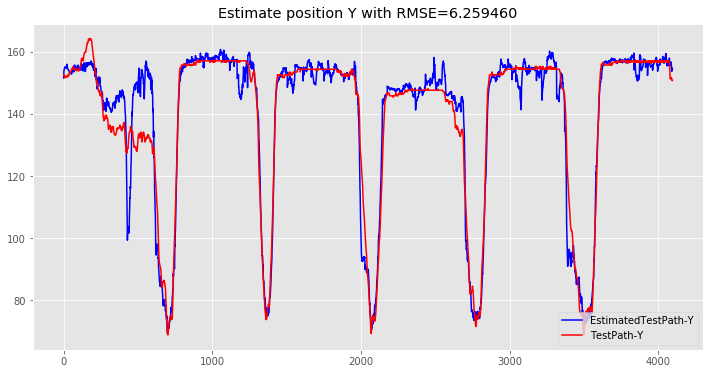

In [14]:
plt.figure(num=None, figsize=(12, 6))

plt1=plt.plot(y_predic[0:,1],'b',label="EstimatedTestPath-Y")


plt.plot(y_test[0:,1],'r',label="TestPath-Y")

plt.legend(loc=4)
plt.title('Estimate position Y with RMSE=%f'%rmsY)
plt.savefig('EstimatedTestPath-Y.png',format='png',transparent=False)

### plot and save prediction X Test path

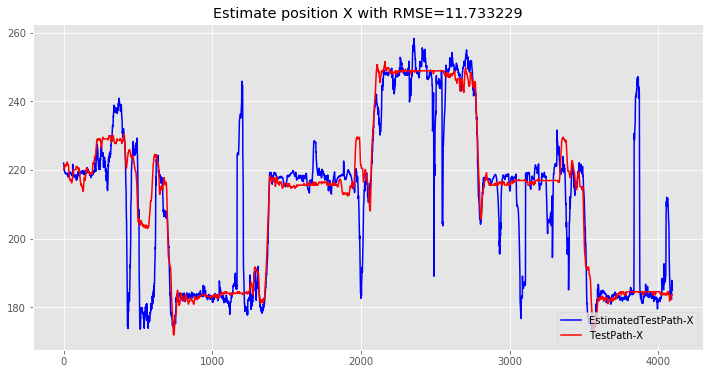

In [16]:
plt.figure(num=None, figsize=(12, 6))

plt1=plt.plot(y_predic[0:,0],'b',label="EstimatedTestPath-X")


plt.plot(y_test[0:,0],'r',label="TestPath-X")

plt.legend(loc=4)
plt.title('Estimate position X with RMSE=%f'%rmsX)

#Save figure
plt.savefig('EstimatedTestPath-X.png',format='png',transparent=False)